In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [26]:
# check if GPU working 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# switch off cudnn 
torch.backends.cudnn.enabled = False

print(device)


cuda


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class EFR_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, output_size):
        super(EFR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Add this line to match dimensions for CRF
        self.crf = CRF(output_size)

    def forward(self, x, tags=None):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = x.squeeze(1)  # This might need adjusting depending on your input shape
        x, _ = self.bilstm(x)
        x = self.fc(x)  # Apply linear transformation to match CRF input requirements
        if tags is not None:
            print("X:", x)
            print("Tags:", tags)
            

            loss = self.crf(x, tags)
            return loss
        else:
            predictions = self.crf.decode(x)
            return predictions

batch_size = 1
speakers = 10
num_utterances = 24
embedding_size = 768
cnn_mid_channels = 3
cnn_out_channels = 1
hidden_lstm = 64
layers_lstm = 1
output_mlp = number_of_emotions = 7

model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                output_size=output_mlp)

input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)
output = model(input_tensor)
print("Output:", output)



Output: [[0], [2], [4], [4], [0], [4], [0], [4], [4], [4], [4], [2], [4], [4], [2], [2], [2], [4], [4], [4], [0], [2], [2], [4]]


In [28]:

class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_trigger_matrix(self, row):
        triggers = row['triggers']
        trigger_matrix = np.zeros((len(triggers), 2))
        for idx, trigger in enumerate(triggers):
            if trigger is None:
                trigger = 0
            trigger_matrix[idx][int(trigger)] = 1
        return trigger_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_trigger_matrix(self.train_data.iloc[idx])
        # print(X.shape, Y.shape)
        return X, Y

In [29]:
# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_triggers = 2



In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [31]:
folder_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 4/"
folder_path = ""

path_train_file = "train_file.json"
path_val_file = "val_file.json"

dataset = MyDataset(path_train_file)
val_dataset = MyDataset(path_val_file)

criterion = nn.CrossEntropyLoss().to(DEVICE)

model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                output_size=output_mlp).to(DEVICE)


optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)



In [32]:
import os 

if os.path.exists(folder_path + 'm4.pth'):
    model.load_state_dict(torch.load(folder_path + 'm4.pth'))
    print("Model Loaded")

else : 

    model.train()

    from tqdm import tqdm
    num_epochs = 1
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
                                                          
            labels = labels.argmax(dim=-1)            
            optimizer.zero_grad()
            
            # convert to long 

            tags = labels.long()
            loss = model(inputs.float(), tags=tags)

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")
        torch.save(model.state_dict(), folder_path + 'm4.pth')


  0%|          | 6/6740 [00:00<01:54, 58.86it/s]

X: tensor([[[-0.1081, -0.1087],
         [-0.1533, -0.1373],
         [-0.1811, -0.1501],
         [-0.2026, -0.1480],
         [-0.2150, -0.1335]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[1, 1, 0, 0, 0]], device='cuda:0')
X: tensor([[[-0.4512,  0.2001],
         [-0.5435,  0.2458],
         [-0.5891,  0.2707],
         [-0.6143,  0.2836],
         [-0.6292,  0.2922],
         [-0.6383,  0.2960],
         [-0.6433,  0.3020],
         [-0.6479,  0.3056],
         [-0.6534,  0.3098],
         [-0.6582,  0.3136],
         [-0.6635,  0.3189],
         [-0.6680,  0.3273],
         [-0.6678,  0.3388],
         [-0.6569,  0.3498],
         [-0.6085,  0.3400]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-0.8572,  0.5127],
         [-0.9870,  0.6148],
         [-1.0396,  0.6696],
         [-1.0556,  0.6997],
         [-1.0489,  0.7113],
         [-1.0108,  0.7061],
         [-0.9012,  0

  0%|          | 18/6740 [00:00<02:11, 51.05it/s]

X: tensor([[[-2.6871,  2.2823],
         [-3.0219,  2.6050],
         [-3.1078,  2.6950],
         [-3.1318,  2.7227],
         [-3.1392,  2.7323],
         [-3.1428,  2.7370],
         [-3.1437,  2.7394],
         [-3.1445,  2.7410],
         [-3.1447,  2.7414],
         [-3.1444,  2.7413],
         [-3.1436,  2.7403],
         [-3.1429,  2.7388],
         [-3.1410,  2.7353],
         [-3.1364,  2.7286],
         [-3.1249,  2.7153],
         [-3.0935,  2.6826],
         [-2.9849,  2.5874],
         [-2.5900,  2.2778]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]],
       device='cuda:0')
X: tensor([[[-2.8728,  2.4847],
         [-3.2202,  2.8276],
         [-3.3026,  2.9187],
         [-3.3237,  2.9447],
         [-3.3294,  2.9540],
         [-3.3302,  2.9553],
         [-3.3290,  2.9543],
         [-3.3253,  2.9487],
         [-3.3141,  2.9351],
         [-3.2827,  2.9009],
         [-3.1720,  2.7986],
         [-2.7

  0%|          | 30/6740 [00:00<02:06, 52.88it/s]

X: tensor([[[-4.5302,  4.2056],
         [-5.0032,  4.7594],
         [-5.0606,  4.8475],
         [-4.9404,  4.7577],
         [-4.2946,  4.2191]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-4.6670,  4.3452],
         [-5.1580,  4.9195],
         [-5.2435,  5.0298],
         [-5.2580,  5.0511],
         [-5.2605,  5.0559],
         [-5.2613,  5.0573],
         [-5.2613,  5.0577],
         [-5.2614,  5.0580],
         [-5.2610,  5.0581],
         [-5.2610,  5.0578],
         [-5.2598,  5.0570],
         [-5.2545,  5.0528],
         [-5.2294,  5.0326],
         [-5.0970,  4.9238],
         [-4.4342,  4.3711]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-4.8018,  4.4860],
         [-5.3043,  5.0757],
         [-5.3901,  5.1866],
         [-5.4034,  5.2065],
         [-5.4013,  5.2072],
         [-5.3785,  5.1896],
         [-5.2484,  5

  1%|          | 36/6740 [00:00<02:15, 49.53it/s]

X: tensor([[[-5.9141,  5.6939],
         [-6.5157,  6.4022],
         [-6.6094,  6.5180],
         [-6.6034,  6.5185],
         [-6.4751,  6.4065],
         [-5.6999,  5.7355]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-6.0278,  5.8156],
         [-6.6222,  6.5181],
         [-6.5902,  6.5220],
         [-5.8181,  5.8573]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-6.1444,  5.9382],
         [-6.7712,  6.6708],
         [-6.8715,  6.7913],
         [-6.8832,  6.8072],
         [-6.8652,  6.7921],
         [-6.7336,  6.6756],
         [-5.9361,  5.9809]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-6.2548,  6.0536],
         [-6.8936,  6.7975],
         [-6.9962,  6.9195],
         [-7.0113,  6.9382],
         [-7.0130,  6.9407],
         [-7.0102,  6.9384],
         [-6.9902,  6.9203],
       

  1%|          | 50/6740 [00:00<02:00, 55.61it/s]

tensor([[[-6.9620,  6.7879],
         [-7.6759,  7.6095],
         [-7.7699,  7.7232],
         [-7.6453,  7.6168],
         [-6.7657,  6.8413]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-7.0519,  6.8878],
         [-7.6386,  7.6007],
         [-6.8608,  6.9454]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-7.1819,  7.0240],
         [-7.9209,  7.8770],
         [-8.0183,  7.9966],
         [-7.8908,  7.8884],
         [-6.9872,  7.0898]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-7.2852,  7.1358],
         [-8.0396,  8.0068],
         [-8.1600,  8.1483],
         [-8.1767,  8.1695],
         [-8.1763,  8.1701],
         [-8.1552,  8.1519],
         [-8.0092,  8.0216],
         [-7.0917,  7.2088]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tens

  1%|          | 64/6740 [00:01<01:51, 59.71it/s]

X: tensor([[[-8.2904,  8.1840],
         [-9.1578,  9.1723],
         [-9.2937,  9.3285],
         [-9.3130,  9.3512],
         [-9.3157,  9.3547],
         [-9.3160,  9.3552],
         [-9.3161,  9.3553],
         [-9.3160,  9.3553],
         [-9.3155,  9.3549],
         [-9.3122,  9.3518],
         [-9.2890,  9.3308],
         [-9.1271,  9.1850],
         [-8.1014,  8.2648]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-8.3845,  8.2796],
         [-9.2622,  9.2787],
         [-9.3996,  9.4367],
         [-9.4190,  9.4597],
         [-9.4218,  9.4632],
         [-9.4221,  9.4638],
         [-9.4221,  9.4639],
         [-9.4216,  9.4635],
         [-9.4182,  9.4604],
         [-9.3948,  9.4393],
         [-9.2314,  9.2920],
         [-8.1953,  8.3615]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-8.4853,  8.3816],
      

  1%|          | 78/6740 [00:01<01:49, 60.89it/s]

X: tensor([[[ -9.5815,   9.4808],
         [-10.5962,  10.6181],
         [-10.7545,  10.7957],
         [-10.7768,  10.8207],
         [-10.7794,  10.8238],
         [-10.7761,  10.8209],
         [-10.7501,  10.7970],
         [-10.5667,  10.6299],
         [ -9.3986,   9.5679]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0, 1, 1, 0, 1, 0]], device='cuda:0')
X: tensor([[[ -9.6857,   9.5851],
         [-10.7088,  10.7310],
         [-10.8426,  10.8863],
         [-10.6801,  10.7428],
         [ -9.5036,   9.6728]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[ -9.7875,   9.6869],
         [-10.8261,  10.8480],
         [-10.9880,  11.0292],
         [-11.0109,  11.0548],
         [-11.0141,  11.0584],
         [-11.0144,  11.0589],
         [-11.0140,  11.0584],
         [-11.0102,  11.0550],
         [-10.9836,  11.0306],
         [-10.7968,  10.8600],
         [ -9.6059,   9.7752]]], device='cuda:0',

  1%|▏         | 91/6740 [00:01<02:01, 54.66it/s]

X: tensor([[[-10.8778,  10.7776],
         [-12.0431,  12.0652],
         [-12.2242,  12.2655],
         [-12.2497,  12.2937],
         [-12.2532,  12.2976],
         [-12.2531,  12.2976],
         [-12.2491,  12.2938],
         [-12.2200,  12.2670],
         [-12.0148,  12.0781],
         [-10.7031,  10.8728]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-10.9795,  10.8794],
         [-12.1566,  12.1787],
         [-12.3396,  12.3808],
         [-12.3653,  12.4093],
         [-12.3689,  12.4133],
         [-12.3694,  12.4138],
         [-12.3694,  12.4139],
         [-12.3694,  12.4139],
         [-12.3694,  12.4138],
         [-12.3688,  12.4133],
         [-12.3646,  12.4094],
         [-12.3353,  12.3823],
         [-12.1284,  12.1917],
         [-10.8055,  10.9751]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]], device='cuda:0')
X: tensor([[[-11.0895,

  1%|▏         | 97/6740 [00:01<02:02, 54.08it/s]

X: tensor([[[-12.0799,  11.9801],
         [-13.3844,  13.4066],
         [-13.5868,  13.6281],
         [-13.6152,  13.6592],
         [-13.6191,  13.6635],
         [-13.6197,  13.6641],
         [-13.6196,  13.6641],
         [-13.6190,  13.6635],
         [-13.6145,  13.6594],
         [-13.5826,  13.6297],
         [-13.3570,  13.4203],
         [-11.9108,  12.0807]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-12.2052,  12.1054],
         [-13.5242,  13.5464],
         [-13.7288,  13.7701],
         [-13.7575,  13.8015],
         [-13.7615,  13.8059],
         [-13.7620,  13.8065],
         [-13.7621,  13.8066],
         [-13.7621,  13.8066],
         [-13.7621,  13.8066],
         [-13.7620,  13.8065],
         [-13.7614,  13.8059],
         [-13.7568,  13.8017],
         [-13.7246,  13.7717],
         [-13.4968,  13.5601],
         [-12.0367,  12.2065]]], device='cuda:0', grad_fn=<ViewBackward0>)

  2%|▏         | 109/6740 [00:02<02:12, 49.99it/s]

X: tensor([[[-13.4544,  13.3549],
         [-14.9177,  14.9401],
         [-15.1443,  15.1857],
         [-15.1760,  15.2201],
         [-15.1804,  15.2249],
         [-15.1810,  15.2255],
         [-15.1811,  15.2256],
         [-15.1811,  15.2256],
         [-15.1811,  15.2256],
         [-15.1811,  15.2256],
         [-15.1810,  15.2255],
         [-15.1803,  15.2249],
         [-15.1754,  15.2203],
         [-15.1403,  15.1874],
         [-14.8912,  14.9545],
         [-13.2912,  13.4612]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-13.5904,  13.4909],
         [-15.0694,  15.0918],
         [-15.2984,  15.3398],
         [-15.3305,  15.3745],
         [-15.3349,  15.3793],
         [-15.3355,  15.3800],
         [-15.3356,  15.3801],
         [-15.3356,  15.3801],
         [-15.3356,  15.3801],
         [-15.3356,  15.3801],
         [-15.3356,  15.3801],
         [-15.3355,  15.3800],


  2%|▏         | 121/6740 [00:02<02:10, 50.58it/s]

X: tensor([[[-14.7608,  14.6641],
         [-16.1077,  16.1490],
         [-14.6066,  14.7735]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1]], device='cuda:0')
X: tensor([[[-14.6040,  14.5236],
         [-14.4719,  14.6199]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0]], device='cuda:0')
X: tensor([[[-15.0321,  14.9328],
         [-16.6773,  16.6997],
         [-16.9317,  16.9731],
         [-16.9672,  17.0113],
         [-16.9721,  17.0165],
         [-16.9727,  17.0173],
         [-16.9728,  17.0174],
         [-16.9728,  17.0174],
         [-16.9728,  17.0174],
         [-16.9728,  17.0174],
         [-16.9728,  17.0174],
         [-16.9727,  17.0173],
         [-16.9720,  17.0165],
         [-16.9666,  17.0114],
         [-16.9277,  16.9749],
         [-16.6516,  16.7150],
         [-14.8746,  15.0447]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor

  2%|▏         | 133/6740 [00:02<02:09, 51.20it/s]

X: tensor([[[-16.0940,  15.9950],
         [-17.8612,  17.8838],
         [-18.1341,  18.1756],
         [-18.1713,  18.2155],
         [-18.1708,  18.2157],
         [-18.1303,  18.1774],
         [-17.8361,  17.8995],
         [-15.9397,  16.1098]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-16.1603,  16.0638],
         [-17.6444,  17.6858],
         [-16.0101,  16.1771]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-16.3146,  16.2155],
         [-18.1071,  18.1297],
         [-18.3839,  18.4254],
         [-18.4225,  18.4666],
         [-18.4278,  18.4723],
         [-18.4284,  18.4729],
         [-18.4277,  18.4723],
         [-18.4219,  18.4668],
         [-18.3801,  18.4272],
         [-18.0820,  18.1455],
         [-16.1609,  16.3310]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor

  2%|▏         | 140/6740 [00:02<02:03, 53.36it/s]

X: tensor([[[-17.1967,  17.0979],
         [-19.0905,  19.1131],
         [-19.3827,  19.4243],
         [-19.4234,  19.4675],
         [-19.4289,  19.4734],
         [-19.4288,  19.4734],
         [-19.4228,  19.4677],
         [-19.3790,  19.4261],
         [-19.0659,  19.1293],
         [-17.0455,  17.2157]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-17.3083,  17.2094],
         [-19.2147,  19.2374],
         [-19.5081,  19.5496],
         [-19.5429,  19.5874],
         [-19.5044,  19.5515],
         [-19.1902,  19.2536],
         [-17.1574,  17.3275]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-17.4170,  17.3182],
         [-19.3359,  19.3586],
         [-19.6311,  19.6727],
         [-19.6662,  19.7107],
         [-19.6275,  19.6746],
         [-19.3114,  19.3749],
         [-17.2664,  17.4365]]], device='cuda:0', grad_fn=<ViewBackward

  2%|▏         | 152/6740 [00:02<02:07, 51.51it/s]

X: tensor([[[-18.4635,  18.3649],
         [-20.5025,  20.5253],
         [-20.8168,  20.8583],
         [-20.8595,  20.9038],
         [-20.8591,  20.9040],
         [-20.8131,  20.8603],
         [-20.4785,  20.5420],
         [-18.3157,  18.4858]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-18.5692,  18.4705],
         [-20.6203,  20.6431],
         [-20.9365,  20.9781],
         [-20.9805,  21.0247],
         [-20.9865,  21.0311],
         [-20.9873,  21.0319],
         [-20.9874,  21.0321],
         [-20.9874,  21.0321],
         [-20.9874,  21.0321],
         [-20.9874,  21.0321],
         [-20.9874,  21.0321],
         [-20.9874,  21.0321],
         [-20.9873,  21.0319],
         [-20.9864,  21.0311],
         [-20.9799,  21.0249],
         [-20.9329,  20.9801],
         [-20.5963,  20.6598],
         [-18.4216,  18.5918]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 

  2%|▏         | 164/6740 [00:03<02:09, 50.82it/s]

X: tensor([[[-19.5462,  19.4477],
         [-21.7093,  21.7322],
         [-22.0426,  22.0843],
         [-22.0889,  22.1332],
         [-22.0952,  22.1399],
         [-22.0961,  22.1408],
         [-22.0962,  22.1409],
         [-22.0962,  22.1409],
         [-22.0962,  22.1409],
         [-22.0961,  22.1408],
         [-22.0951,  22.1399],
         [-22.0883,  22.1334],
         [-22.0390,  22.0863],
         [-21.6857,  21.7493],
         [-19.4010,  19.5713]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], device='cuda:0')
X: tensor([[[-19.6521,  19.5537],
         [-21.8273,  21.8502],
         [-22.1615,  22.2032],
         [-22.2012,  22.2458],
         [-22.1580,  22.2052],
         [-21.8038,  21.8673],
         [-19.5073,  19.6775]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-19.7556,  19.6572],
         [-21.9427,  21.9657],
         [-22.2787,  22.3

  3%|▎         | 170/6740 [00:03<02:12, 49.41it/s]

X: tensor([[[-20.6143,  20.5190],
         [-22.5344,  22.5765],
         [-20.4757,  20.6430]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-20.7693,  20.6715],
         [-23.0727,  23.0962],
         [-23.4274,  23.4696],
         [-23.4765,  23.5214],
         [-23.4833,  23.5285],
         [-23.4842,  23.5295],
         [-23.4843,  23.5296],
         [-23.4842,  23.5295],
         [-23.4832,  23.5285],
         [-23.4760,  23.5216],
         [-23.4239,  23.4717],
         [-23.0497,  23.1137],
         [-20.6274,  20.7978]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-20.8087,  20.7136],
         [-22.7478,  22.7900],
         [-20.6706,  20.8380]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-20.9623,  20.8649],
         [-23.2879,  23.3118],
         [-23.6459,  23.6885],
         [-23.6

  3%|▎         | 183/6740 [00:03<02:08, 50.88it/s]

X: tensor([[[-21.6971,  21.6135],
         [-24.0543,  24.0929],
         [-24.0360,  24.1058],
         [-21.5609,  21.7333]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-21.7291,  21.6511],
         [-23.7594,  23.8145],
         [-21.5960,  21.7673]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-21.8727,  21.7981],
         [-24.3032,  24.3498],
         [-24.6772,  24.7425],
         [-24.7290,  24.7970],
         [-24.7361,  24.8044],
         [-24.7370,  24.8054],
         [-24.7370,  24.8054],
         [-24.7360,  24.8043],
         [-24.7285,  24.7968],
         [-24.6740,  24.7433],
         [-24.2817,  24.3627],
         [-21.7367,  21.9128]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-21.9610,  21.8915],
         [-24.4016,  24.4533],
         [-24.7771,  24.8476],
         [-24.8

  3%|▎         | 197/6740 [00:03<01:56, 56.20it/s]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-22.8956,  22.8359],
         [-25.4333,  25.4951],
         [-25.7677,  25.8503],
         [-25.4110,  25.5112],
         [-22.7549,  22.9540]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-22.9780,  22.9183],
         [-25.5325,  25.5941],
         [-25.9253,  26.0055],
         [-25.9786,  26.0615],
         [-25.9782,  26.0617],
         [-25.9219,  26.0075],
         [-25.5097,  25.6104],
         [-22.8369,  23.0361]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0, 1, 0]], device='cuda:0')
X: tensor([[[-23.0596,  22.9999],
         [-25.6232,  25.6848],
         [-26.0175,  26.0977],
         [-26.0721,  26.1549],
         [-26.0796,  26.1627],
         [-26.0806,  26.1638],
         [-26.0807,  26.1640],
         [-26.0807,  26.1640],
         [-26.0807,  26.1640],
         [-26.0807,  26.1640],
         [-26.0807,  26.1

  3%|▎         | 210/6740 [00:03<01:57, 55.40it/s]

X: tensor([[[-23.8947,  23.8351],
         [-26.5517,  26.6132],
         [-26.9602,  27.0404],
         [-27.0167,  27.0995],
         [-27.0244,  27.1076],
         [-27.0255,  27.1087],
         [-27.0256,  27.1089],
         [-27.0256,  27.1089],
         [-27.0254,  27.1087],
         [-27.0243,  27.1076],
         [-27.0162,  27.0997],
         [-26.9567,  27.0423],
         [-26.5284,  26.6291],
         [-23.7501,  23.9498]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-23.9946,  23.9350],
         [-26.6628,  26.7244],
         [-27.0730,  27.1533],
         [-27.1298,  27.2126],
         [-27.1375,  27.2207],
         [-27.1386,  27.2218],
         [-27.1387,  27.2220],
         [-27.1388,  27.2220],
         [-27.1388,  27.2220],
         [-27.1388,  27.2220],
         [-27.1388,  27.2220],
         [-27.1387,  27.2220],
         [-27.1386,  27.2218],
         [-27.1374,  27.2207],
      

  3%|▎         | 216/6740 [00:04<02:08, 50.69it/s]

X: tensor([[[-24.8706,  24.8110],
         [-27.6367,  27.6983],
         [-28.0619,  28.1421],
         [-28.1207,  28.2035],
         [-28.1287,  28.2119],
         [-28.1298,  28.2131],
         [-28.1299,  28.2132],
         [-28.1299,  28.2132],
         [-28.1298,  28.2131],
         [-28.1286,  28.2119],
         [-28.1201,  28.2037],
         [-28.0583,  28.1440],
         [-27.6129,  27.7137],
         [-24.7224,  24.9221]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-24.9762,  24.9166],
         [-27.7540,  27.8156],
         [-28.1798,  28.2601],
         [-28.2303,  28.3135],
         [-28.1763,  28.2619],
         [-27.7302,  27.8309],
         [-24.8277,  25.0273]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-25.0794,  25.0199],
         [-27.8678,  27.9294],
         [-28.2880,  28.3686],
         [-28.2850,  28.3702

  3%|▎         | 229/6740 [00:04<02:01, 53.42it/s]

X: tensor([[[-25.8986,  25.8391],
         [-28.7799,  28.8415],
         [-29.2225,  29.3028],
         [-29.2825,  29.3654],
         [-29.2821,  29.3656],
         [-29.2189,  29.3046],
         [-28.7556,  28.8564],
         [-25.7469,  25.9466]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 1, 0]], device='cuda:0')
X: tensor([[[-25.9299,  25.8727],
         [-28.3578,  28.4369],
         [-25.7814,  25.9781]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-26.1028,  26.0433],
         [-29.0071,  29.0687],
         [-29.4534,  29.5336],
         [-29.5151,  29.5979],
         [-29.5235,  29.6067],
         [-29.5246,  29.6079],
         [-29.5247,  29.6080],
         [-29.5246,  29.6079],
         [-29.5234,  29.6067],
         [-29.5145,  29.5981],
         [-29.4497,  29.5354],
         [-28.9827,  29.0835],
         [-25.9505,  26.1502]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([

  4%|▎         | 242/6740 [00:04<01:58, 54.95it/s]

X: tensor([[[-26.9130,  26.8535],
         [-29.9083,  29.9699],
         [-30.3684,  30.4487],
         [-30.4320,  30.5149],
         [-30.4407,  30.5239],
         [-30.4419,  30.5251],
         [-30.4420,  30.5253],
         [-30.4419,  30.5251],
         [-30.4406,  30.5239],
         [-30.4315,  30.5151],
         [-30.3647,  30.4504],
         [-29.8836,  29.9843],
         [-26.7584,  26.9582]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-27.0068,  26.9474],
         [-30.0037,  30.0656],
         [-30.3985,  30.4812],
         [-29.9795,  30.0799],
         [-26.8522,  27.0518]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-27.0996,  27.0401],
         [-30.1159,  30.1775],
         [-30.5791,  30.6594],
         [-30.6419,  30.7248],
         [-30.6414,  30.7249],
         [-30.5754,  30.6611],
         [-30.0912,  30.1919],
      

  4%|▍         | 254/6740 [00:04<02:05, 51.79it/s]

X: tensor([[[-27.9256,  27.8662],
         [-31.0257,  31.0876],
         [-31.4341,  31.5168],
         [-31.0013,  31.1016],
         [-27.7690,  27.9687]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-28.0186,  27.9591],
         [-31.1384,  31.2000],
         [-31.6175,  31.6978],
         [-31.6836,  31.7664],
         [-31.6913,  31.7745],
         [-31.6830,  31.7666],
         [-31.6138,  31.6995],
         [-31.1134,  31.2142],
         [-27.8617,  28.0614]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-28.1120,  28.0526],
         [-31.2424,  31.3040],
         [-31.7231,  31.8034],
         [-31.7896,  31.8724],
         [-31.7986,  31.8818],
         [-31.7999,  31.8831],
         [-31.8000,  31.8833],
         [-31.8000,  31.8833],
         [-31.8000,  31.8833],
         [-31.8000,  31.8833],
         [-31.8000,  31.8833],
         [-31.7998

  4%|▍         | 260/6740 [00:04<02:07, 50.69it/s]

X: tensor([[[-28.8717,  28.8123],
         [-32.0881,  32.1497],
         [-32.5820,  32.6623],
         [-32.6503,  32.7331],
         [-32.6595,  32.7427],
         [-32.6608,  32.7441],
         [-32.6610,  32.7442],
         [-32.6610,  32.7443],
         [-32.6610,  32.7443],
         [-32.6610,  32.7443],
         [-32.6610,  32.7443],
         [-32.6610,  32.7443],
         [-32.6610,  32.7442],
         [-32.6608,  32.7441],
         [-32.6595,  32.7428],
         [-32.6497,  32.7333],
         [-32.5783,  32.6640],
         [-32.0630,  32.1638],
         [-28.7139,  28.9136]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]],
       device='cuda:0')
X: tensor([[[-28.9840,  28.9246],
         [-32.2131,  32.2747],
         [-32.7090,  32.7892],
         [-32.7774,  32.8603],
         [-32.7868,  32.8700],
         [-32.7880,  32.8713],
         [-32.7882,  32.8714],
         [-32.7880,  32.8713],
         [-32.7

  4%|▍         | 273/6740 [00:05<02:04, 51.97it/s]

X: tensor([[[-30.1465,  30.0871],
         [-33.5069,  33.5686],
         [-34.0229,  34.1031],
         [-34.0939,  34.1768],
         [-34.1022,  34.1855],
         [-34.0934,  34.1770],
         [-34.0191,  34.1048],
         [-33.4816,  33.5824],
         [-29.9867,  30.1865]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0]], device='cuda:0')
X: tensor([[[-30.2241,  30.1647],
         [-33.5919,  33.6536],
         [-34.0990,  34.1796],
         [-34.0958,  34.1811],
         [-33.5667,  33.6674],
         [-30.0642,  30.2639]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[1, 0, 0, 1, 1, 0]], device='cuda:0')
X: tensor([[[-30.2986,  30.2392],
         [-33.6761,  33.7378],
         [-34.1947,  34.2750],
         [-34.2663,  34.3492],
         [-34.2758,  34.3591],
         [-34.2758,  34.3591],
         [-34.2657,  34.3493],
         [-34.1910,  34.2767],
         [-33.6508,  33.7516],
         [-30.1385,  30.3383]]], device='cuda:

  4%|▍         | 286/6740 [00:05<02:07, 50.51it/s]

X: tensor([[[-31.0259,  30.9666],
         [-34.4859,  34.5475],
         [-35.0170,  35.0973],
         [-35.0904,  35.1732],
         [-35.1004,  35.1836],
         [-35.1017,  35.1850],
         [-35.1019,  35.1852],
         [-35.1019,  35.1852],
         [-35.1019,  35.1852],
         [-35.1019,  35.1852],
         [-35.1019,  35.1852],
         [-35.1019,  35.1852],
         [-35.1019,  35.1852],
         [-35.1017,  35.1850],
         [-35.1003,  35.1836],
         [-35.0898,  35.1734],
         [-35.0133,  35.0990],
         [-34.4605,  34.5613],
         [-30.8651,  31.0648]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]],
       device='cuda:0')
X: tensor([[[-31.1586,  31.0993],
         [-34.6334,  34.6951],
         [-35.1655,  35.2458],
         [-35.2286,  35.3118],
         [-35.1618,  35.2474],
         [-34.6080,  34.7088],
         [-30.9977,  31.1974]]], device='cuda:0', grad_fn=<ViewBackward0>)
Ta

  4%|▍         | 292/6740 [00:05<02:12, 48.73it/s]

tensor([[[-32.3109,  32.2516],
         [-35.9164,  35.9781],
         [-36.4699,  36.5502],
         [-36.5463,  36.6291],
         [-36.5567,  36.6399],
         [-36.5581,  36.6413],
         [-36.5583,  36.6415],
         [-36.5583,  36.6416],
         [-36.5583,  36.6416],
         [-36.5583,  36.6415],
         [-36.5581,  36.6413],
         [-36.5566,  36.6399],
         [-36.5457,  36.6293],
         [-36.4661,  36.5518],
         [-35.8909,  35.9917],
         [-32.1488,  32.3485]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-32.4201,  32.3607],
         [-36.0379,  36.0996],
         [-36.5930,  36.6733],
         [-36.6682,  36.7511],
         [-36.6677,  36.7513],
         [-36.5893,  36.6750],
         [-36.0123,  36.1131],
         [-32.2578,  32.4575]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-32.5261,  3

  5%|▍         | 304/6740 [00:05<02:05, 51.20it/s]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-33.4912,  33.4319],
         [-37.2305,  37.2921],
         [-37.8043,  37.8846],
         [-37.8836,  37.9664],
         [-37.8943,  37.9775],
         [-37.8958,  37.9790],
         [-37.8960,  37.9793],
         [-37.8960,  37.9793],
         [-37.8960,  37.9793],
         [-37.8958,  37.9791],
         [-37.8942,  37.9776],
         [-37.8830,  37.9666],
         [-37.8006,  37.8863],
         [-37.2048,  37.3056],
         [-33.3279,  33.5276]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-32.9008,  32.8590],
         [-32.7630,  32.9412]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1]], device='cuda:0')
X: tensor([[[-33.6882,  33.6289],
         [-37.4497,  37.5113],
         [-38.0269,  38.1072],
         [-38.1066,  38.1895],
         [-38.1175,  38.2007],
         [-38.1189,  38.2022],
         [-38.11

  5%|▍         | 315/6740 [00:06<02:16, 47.06it/s]

X: tensor([[[-34.3775,  34.3182],
         [-38.2168,  38.2785],
         [-38.8060,  38.8863],
         [-38.8873,  38.9702],
         [-38.8984,  38.9816],
         [-38.8999,  38.9831],
         [-38.9001,  38.9834],
         [-38.9001,  38.9834],
         [-38.9001,  38.9834],
         [-38.9001,  38.9833],
         [-38.8999,  38.9831],
         [-38.8983,  38.9816],
         [-38.8868,  38.9704],
         [-38.8022,  38.8879],
         [-38.1909,  38.2917],
         [-34.2125,  34.4123]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]], device='cuda:0')
X: tensor([[[-34.4986,  34.4393],
         [-38.3501,  38.4118],
         [-38.9298,  39.0104],
         [-38.9266,  39.0118],
         [-38.3242,  38.4250],
         [-34.3335,  34.5332]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-34.6161,  34.5568],
         [-38.4824,  38.5441],
         [-39.0758,  39.1

  5%|▍         | 328/6740 [00:06<01:59, 53.57it/s]

X: tensor([[[-35.5106,  35.4516],
         [-39.3926,  39.4567],
         [-39.3704,  39.4682],
         [-35.3451,  35.5444]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-35.6221,  35.5628],
         [-39.6025,  39.6642],
         [-40.2133,  40.2936],
         [-40.2976,  40.3805],
         [-40.3088,  40.3920],
         [-40.3088,  40.3921],
         [-40.2970,  40.3806],
         [-40.2096,  40.2952],
         [-39.5765,  39.6773],
         [-35.4561,  35.6558]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-35.6207,  35.5638],
         [-38.9777,  39.0569],
         [-35.4583,  35.6551]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-35.8150,  35.7557],
         [-39.8173,  39.8790],
         [-40.4314,  40.5117],
         [-40.5159,  40.5988],
         [-40.5258,  40.6091],
         [-40.5154,  

  5%|▌         | 340/6740 [00:06<01:58, 53.90it/s]

X: tensor([[[-36.6919,  36.6326],
         [-40.7937,  40.8554],
         [-41.4231,  41.5034],
         [-41.5097,  41.5925],
         [-41.5198,  41.6031],
         [-41.5091,  41.5927],
         [-41.4193,  41.5050],
         [-40.7677,  40.8685],
         [-36.5253,  36.7250]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-36.7862,  36.7269],
         [-40.8988,  40.9605],
         [-41.5298,  41.6101],
         [-41.6166,  41.6995],
         [-41.6267,  41.7100],
         [-41.6160,  41.6996],
         [-41.5260,  41.6117],
         [-40.8727,  40.9735],
         [-36.6196,  36.8193]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-36.8808,  36.8215],
         [-41.0041,  41.0658],
         [-41.6367,  41.7170],
         [-41.7240,  41.8069],
         [-41.7358,  41.8191],
         [-41.7375,  41.8207],
         [-41.7376,  41.8209],
      

  5%|▌         | 346/6740 [00:06<01:56, 54.67it/s]

X: tensor([[[-37.7452,  37.6859],
         [-41.9662,  42.0279],
         [-42.6121,  42.6925],
         [-42.6889,  42.7720],
         [-42.6084,  42.6940],
         [-41.9400,  42.0408],
         [-37.5776,  37.7774]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-37.8388,  37.7795],
         [-42.0689,  42.1307],
         [-42.7056,  42.7862],
         [-42.7023,  42.7876],
         [-42.0428,  42.1436],
         [-37.6711,  37.8709]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-37.9156,  37.8567],
         [-42.0648,  42.1289],
         [-42.0423,  42.1402],
         [-37.7484,  37.9477]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-38.0165,  37.9572],
         [-42.2684,  42.3301],
         [-42.9207,  43.0010],
         [-43.0107,  43.0936],
         [-43.0229,  43.1062],
         [-43.0246,  

  5%|▌         | 358/6740 [00:06<02:07, 49.99it/s]

X: tensor([[[-38.6994,  38.6401],
         [-43.0270,  43.0887],
         [-43.6782,  43.7589],
         [-43.6750,  43.7603],
         [-43.0008,  43.1015],
         [-38.5309,  38.7306]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 1, 1, 0]], device='cuda:0')
X: tensor([[[-38.7722,  38.7132],
         [-43.0164,  43.0805],
         [-42.9939,  43.0917],
         [-38.6042,  38.8035]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-38.8549,  38.7959],
         [-43.1083,  43.1724],
         [-43.0858,  43.1836],
         [-38.6868,  38.8861]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-38.9497,  38.8904],
         [-43.3074,  43.3692],
         [-43.9759,  44.0563],
         [-44.0682,  44.1510],
         [-44.0807,  44.1639],
         [-44.0824,  44.1657],
         [-44.0826,  44.1659],
         [-44.0827,  44.1659],
         [-44.0827,  44.1659],

  5%|▌         | 370/6740 [00:07<02:01, 52.51it/s]

X: tensor([[[-39.6508,  39.5916],
         [-44.0751,  44.1372],
         [-44.6587,  44.7415],
         [-44.0494,  44.1498],
         [-39.4818,  39.6815]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-39.7506,  39.6914],
         [-44.1990,  44.2608],
         [-44.8797,  44.9600],
         [-44.9605,  45.0437],
         [-44.8760,  44.9616],
         [-44.1727,  44.2735],
         [-39.5815,  39.7812]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 1, 0]], device='cuda:0')
X: tensor([[[-39.7324,  39.6756],
         [-43.4852,  43.5645],
         [-39.5670,  39.7638]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1]], device='cuda:0')
X: tensor([[[-39.9313,  39.8721],
         [-44.3874,  44.4494],
         [-44.9752,  45.0579],
         [-44.3615,  44.4620],
         [-39.7621,  39.9618]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:

  6%|▌         | 382/6740 [00:07<01:58, 53.60it/s]

X: tensor([[[-40.6885,  40.6293],
         [-45.2436,  45.3053],
         [-45.9423,  46.0226],
         [-46.0386,  46.1215],
         [-46.0517,  46.1350],
         [-46.0535,  46.1368],
         [-46.0537,  46.1370],
         [-46.0538,  46.1371],
         [-46.0538,  46.1371],
         [-46.0538,  46.1371],
         [-46.0537,  46.1370],
         [-46.0535,  46.1368],
         [-46.0517,  46.1350],
         [-46.0381,  46.1217],
         [-45.9385,  46.0242],
         [-45.2171,  45.3180],
         [-40.5186,  40.7184]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-40.7877,  40.7288],
         [-45.2559,  45.3200],
         [-45.2332,  45.3311],
         [-40.6182,  40.8176]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-40.9106,  40.8514],
         [-45.4890,  45.5508],
         [-46.1780,  46.2586],
         [-46.1747,  46.2600

  6%|▌         | 395/6740 [00:07<01:51, 56.96it/s]

X: tensor([[[-41.7262,  41.6694],
         [-45.6706,  45.7498],
         [-41.5586,  41.7554]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0]], device='cuda:0')
X: tensor([[[-41.9118,  41.8526],
         [-46.6052,  46.6670],
         [-47.3251,  47.4054],
         [-47.4244,  47.5072],
         [-47.4376,  47.5208],
         [-47.4375,  47.5208],
         [-47.4238,  47.5074],
         [-47.3213,  47.4070],
         [-46.5786,  46.6794],
         [-41.7402,  41.9399]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-41.9832,  41.9240],
         [-46.6844,  46.7462],
         [-47.4037,  47.4840],
         [-47.4891,  47.5723],
         [-47.3999,  47.4855],
         [-46.6578,  46.7586],
         [-41.8114,  42.0112]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-42.0557,  41.9965],
         [-46.7654,  46.8271],
         [-4

  6%|▌         | 407/6740 [00:07<01:53, 55.72it/s]

X: tensor([[[-42.7287,  42.6695],
         [-47.5144,  47.5761],
         [-48.2484,  48.3287],
         [-48.3496,  48.4325],
         [-48.3633,  48.4466],
         [-48.3649,  48.4482],
         [-48.3633,  48.4466],
         [-48.3491,  48.4327],
         [-48.2446,  48.3303],
         [-47.4876,  47.5884],
         [-42.5557,  42.7554]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-42.8101,  42.7508],
         [-47.6050,  47.6667],
         [-48.3404,  48.4207],
         [-48.4418,  48.5247],
         [-48.4556,  48.5388],
         [-48.4575,  48.5407],
         [-48.4577,  48.5410],
         [-48.4575,  48.5407],
         [-48.4555,  48.5389],
         [-48.4413,  48.5249],
         [-48.3366,  48.4223],
         [-47.5782,  47.6790],
         [-42.6369,  42.8367]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]], device='cuda:0')
X: tensor([[[-42.8971,

  6%|▋         | 422/6740 [00:07<01:46, 59.55it/s]

X: tensor([[[-43.8359,  43.7767],
         [-48.7450,  48.8068],
         [-49.4837,  49.5643],
         [-49.4804,  49.5657],
         [-48.7181,  48.8189],
         [-43.6615,  43.8613]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-43.9010,  43.8421],
         [-48.7141,  48.7782],
         [-48.6909,  48.7888],
         [-43.7271,  43.9264]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-43.9773,  43.9184],
         [-48.7988,  48.8630],
         [-48.7756,  48.8735],
         [-43.8033,  44.0026]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-44.0666,  44.0074],
         [-49.0019,  49.0637],
         [-49.7444,  49.8251],
         [-49.7411,  49.8264],
         [-48.9749,  49.0757],
         [-43.8919,  44.0917]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 1]], device='cuda:

  6%|▋         | 429/6740 [00:08<01:51, 56.82it/s]

X: tensor([[[-44.8085,  44.7492],
         [-49.8297,  49.8914],
         [-50.5997,  50.6800],
         [-50.7056,  50.7885],
         [-50.7180,  50.8013],
         [-50.7051,  50.7887],
         [-50.5958,  50.6815],
         [-49.8025,  49.9034],
         [-44.6329,  44.8327]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 1, 0]], device='cuda:0')
X: tensor([[[-44.8764,  44.8175],
         [-49.7976,  49.8617],
         [-49.7743,  49.8721],
         [-44.7013,  44.9007]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-44.9731,  44.9139],
         [-50.0129,  50.0747],
         [-50.7859,  50.8662],
         [-50.8924,  50.9753],
         [-50.9069,  50.9901],
         [-50.9089,  50.9921],
         [-50.9091,  50.9924],
         [-50.9092,  50.9924],
         [-50.9091,  50.9924],
         [-50.9089,  50.9921],
         [-50.9068,  50.9902],
         [-50.8919,  50.9755],
         [-50.7820,  

  7%|▋         | 441/6740 [00:08<01:49, 57.70it/s]

X: tensor([[[-45.7638,  45.7045],
         [-50.8932,  50.9550],
         [-51.6799,  51.7602],
         [-51.7880,  51.8709],
         [-51.8007,  51.8840],
         [-51.7875,  51.8711],
         [-51.6760,  51.7617],
         [-50.8660,  50.9668],
         [-45.5873,  45.7870]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-45.8302,  45.7713],
         [-50.8573,  50.9214],
         [-50.8339,  50.9317],
         [-45.6542,  45.8535]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-45.9099,  45.8510],
         [-50.9458,  51.0100],
         [-50.9224,  51.0203],
         [-45.7338,  45.9331]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-46.0034,  45.9442],
         [-51.1600,  51.2218],
         [-51.9508,  52.0311],
         [-52.0598,  52.1427],
         [-52.0746,  52.1579],
         [-52.0766,  

  7%|▋         | 453/6740 [00:08<01:55, 54.51it/s]

X: tensor([[[-46.6521,  46.5953],
         [-51.0692,  51.1485],
         [-46.4781,  46.6749]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-46.8544,  46.7955],
         [-51.9949,  52.0591],
         [-51.9714,  52.0692],
         [-46.6770,  46.8764]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-46.9545,  46.8953],
         [-52.2188,  52.2805],
         [-53.0261,  53.1064],
         [-53.1374,  53.2202],
         [-53.1525,  53.2357],
         [-53.1545,  53.2378],
         [-53.1548,  53.2381],
         [-53.1548,  53.2381],
         [-53.1548,  53.2381],
         [-53.1549,  53.2381],
         [-53.1548,  53.2381],
         [-53.1548,  53.2381],
         [-53.1548,  53.2381],
         [-53.1545,  53.2378],
         [-53.1524,  53.2357],
         [-53.1368,  53.2204],
         [-53.0222,  53.1079],
         [-52.1913,  52.2921],
         [-46.7765,  46.9762]]], device

  7%|▋         | 465/6740 [00:08<02:01, 51.61it/s]

X: tensor([[[-47.7209,  47.6617],
         [-53.0717,  53.1335],
         [-53.8902,  53.9705],
         [-53.9874,  54.0706],
         [-53.8863,  53.9720],
         [-53.0441,  53.1450],
         [-47.5419,  47.7416]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-47.8148,  47.7556],
         [-53.1744,  53.2362],
         [-53.9808,  54.0614],
         [-53.9774,  54.0627],
         [-53.1469,  53.2476],
         [-47.6357,  47.8355]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-47.9042,  47.8451],
         [-53.2605,  53.3226],
         [-53.9674,  54.0501],
         [-53.2334,  53.3339],
         [-47.7252,  47.9249]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-47.9945,  47.9353],
         [-53.3764,  53.4382],
         [-54.1996,  54.2799],
         [-54.2974,  54.3806],
         [-54.1957

  7%|▋         | 471/6740 [00:08<02:03, 50.75it/s]

X: tensor([[[-48.7042,  48.6450],
         [-54.1669,  54.2287],
         [-55.0046,  55.0849],
         [-55.1201,  55.2030],
         [-55.1357,  55.2190],
         [-55.1376,  55.2208],
         [-55.1357,  55.2190],
         [-55.1195,  55.2031],
         [-55.0007,  55.0864],
         [-54.1393,  54.2401],
         [-48.5246,  48.7244]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-48.7879,  48.7287],
         [-54.2602,  54.3220],
         [-55.0994,  55.1797],
         [-55.2150,  55.2979],
         [-55.2308,  55.3140],
         [-55.2329,  55.3162],
         [-55.2332,  55.3165],
         [-55.2332,  55.3165],
         [-55.2332,  55.3165],
         [-55.2332,  55.3165],
         [-55.2329,  55.3162],
         [-55.2307,  55.3140],
         [-55.2145,  55.2981],
         [-55.0954,  55.1811],
         [-54.2325,  54.3334],
         [-48.6084,  48.8081]]], device='cuda:0', grad_fn=<ViewBackward0>)
Ta

  7%|▋         | 484/6740 [00:09<01:58, 52.84it/s]

X: tensor([[[-49.5991,  49.5400],
         [-55.1636,  55.2253],
         [-56.0168,  56.0972],
         [-56.1344,  56.2173],
         [-56.1504,  56.2336],
         [-56.1522,  56.2355],
         [-56.1503,  56.2336],
         [-56.1339,  56.2175],
         [-56.0129,  56.0986],
         [-55.1358,  55.2367],
         [-49.4192,  49.6189]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-49.6824,  49.6235],
         [-55.1372,  55.2013],
         [-55.1134,  55.2112],
         [-49.5029,  49.7022]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-49.7976,  49.7384],
         [-55.3846,  55.4463],
         [-56.2410,  56.3213],
         [-56.3568,  56.4398],
         [-56.3564,  56.4399],
         [-56.2371,  56.3228],
         [-55.3568,  55.4577],
         [-49.6176,  49.8173]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 

  7%|▋         | 496/6740 [00:09<02:00, 52.00it/s]

X: tensor([[[-50.7162,  50.6571],
         [-56.4074,  56.4692],
         [-57.2801,  57.3604],
         [-57.4004,  57.4833],
         [-57.4167,  57.5000],
         [-57.4190,  57.5022],
         [-57.4193,  57.5025],
         [-57.4193,  57.5026],
         [-57.4193,  57.5025],
         [-57.4190,  57.5022],
         [-57.4167,  57.5000],
         [-57.3999,  57.4835],
         [-57.2762,  57.3619],
         [-56.3796,  56.4804],
         [-50.5354,  50.7351]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]], device='cuda:0')
X: tensor([[[-50.8179,  50.7587],
         [-56.5206,  56.5823],
         [-57.3947,  57.4750],
         [-57.5130,  57.5959],
         [-57.5125,  57.5960],
         [-57.3908,  57.4765],
         [-56.4927,  56.5936],
         [-50.6370,  50.8367]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-50.8997,  50.8408],
         [-56.4897,  5

  8%|▊         | 509/6740 [00:09<02:05, 49.71it/s]

X: tensor([[[-51.8447,  51.7855],
         [-57.6638,  57.7256],
         [-58.5561,  58.6364],
         [-58.6791,  58.7620],
         [-58.6957,  58.7790],
         [-58.6977,  58.7810],
         [-58.6957,  58.7790],
         [-58.6785,  58.7621],
         [-58.5521,  58.6378],
         [-57.6358,  57.7367],
         [-51.6627,  51.8625]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]], device='cuda:0')
X: tensor([[[-51.9307,  51.8715],
         [-57.7427,  57.8048],
         [-58.5099,  58.5927],
         [-57.7153,  57.8157],
         [-51.7488,  51.9485]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-51.8720,  51.8152],
         [-56.7915,  56.8709],
         [-51.6939,  51.8907]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1]], device='cuda:0')
X: tensor([[[-52.0982,  52.0390],
         [-57.9462,  58.0079],
         [-58.8428,  58.9231],
         [-58.9

  8%|▊         | 515/6740 [00:09<02:05, 49.52it/s]

X: tensor([[[-52.6912,  52.6320],
         [-58.6065,  58.6683],
         [-59.5135,  59.5938],
         [-59.6385,  59.7214],
         [-59.6554,  59.7387],
         [-59.6574,  59.7407],
         [-59.6554,  59.7387],
         [-59.6380,  59.7216],
         [-59.5095,  59.5952],
         [-58.5785,  58.6793],
         [-52.5088,  52.7085]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-52.7862,  52.7274],
         [-58.5859,  58.6501],
         [-58.5619,  58.6597],
         [-52.6043,  52.8037]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-52.9142,  52.8550],
         [-58.8545,  58.9163],
         [-59.7630,  59.8434],
         [-59.8711,  59.9543],
         [-59.7591,  59.8448],
         [-58.8265,  58.9273],
         [-52.7317,  52.9314]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor

  8%|▊         | 526/6740 [00:10<02:14, 46.27it/s]

X: tensor([[[-53.8819,  53.8227],
         [-59.9327,  59.9945],
         [-60.8605,  60.9408],
         [-60.9883,  61.0712],
         [-61.0057,  61.0889],
         [-61.0081,  61.0913],
         [-61.0084,  61.0917],
         [-61.0084,  61.0917],
         [-61.0084,  61.0917],
         [-61.0084,  61.0917],
         [-61.0080,  61.0913],
         [-61.0056,  61.0890],
         [-60.9878,  61.0714],
         [-60.8565,  60.9422],
         [-59.9047,  60.0055],
         [-53.6994,  53.8991]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-53.9982,  53.9390],
         [-60.0623,  60.1240],
         [-60.9921,  61.0724],
         [-61.1202,  61.2031],
         [-61.1376,  61.2208],
         [-61.1399,  61.2232],
         [-61.1399,  61.2232],
         [-61.1375,  61.2208],
         [-61.1196,  61.2033],
         [-60.9881,  61.0738],
         [-60.0342,  60.1351],
         [-53.8157,  54.0154]]]

  8%|▊         | 537/6740 [00:10<02:07, 48.52it/s]

X: tensor([[[-55.0450,  54.9859],
         [-61.2284,  61.2901],
         [-62.1764,  62.2567],
         [-62.3071,  62.3900],
         [-62.3248,  62.4081],
         [-62.3272,  62.4105],
         [-62.3276,  62.4108],
         [-62.3276,  62.4109],
         [-62.3276,  62.4109],
         [-62.3276,  62.4109],
         [-62.3276,  62.4109],
         [-62.3276,  62.4109],
         [-62.3272,  62.4105],
         [-62.3248,  62.4081],
         [-62.3065,  62.3902],
         [-62.1725,  62.2582],
         [-61.2004,  61.3012],
         [-54.8626,  55.0624]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],
       device='cuda:0')
X: tensor([[[-55.1550,  55.0959],
         [-61.3509,  61.4127],
         [-62.3009,  62.3812],
         [-62.4319,  62.5147],
         [-62.4496,  62.5328],
         [-62.4520,  62.5353],
         [-62.4523,  62.5356],
         [-62.4520,  62.5353],
         [-62.4496,  62.5329],
         [-62.4313

  8%|▊         | 550/6740 [00:10<01:55, 53.49it/s]

tensor([[[-56.1213,  56.0621],
         [-62.4273,  62.4891],
         [-63.3941,  63.4744],
         [-63.5270,  63.6099],
         [-63.5426,  63.6258],
         [-63.5265,  63.6101],
         [-63.3901,  63.4758],
         [-62.3993,  62.5001],
         [-55.9390,  56.1388]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0]], device='cuda:0')
X: tensor([[[-56.2251,  56.1659],
         [-62.5428,  62.6046],
         [-63.5112,  63.5915],
         [-63.6421,  63.7251],
         [-63.6417,  63.7252],
         [-63.5072,  63.5929],
         [-62.5149,  62.6157],
         [-56.0428,  56.2426]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-56.3281,  56.2689],
         [-62.6576,  62.7194],
         [-63.6281,  63.7084],
         [-63.7618,  63.8447],
         [-63.7800,  63.8632],
         [-63.7824,  63.8657],
         [-63.7828,  63.8660],
         [-63.7828,  63.8661],
         [-6

  8%|▊         | 556/6740 [00:10<02:05, 49.32it/s]

X: tensor([[[-57.3108,  57.2516],
         [-63.7518,  63.8136],
         [-64.7393,  64.8196],
         [-64.8754,  64.9583],
         [-64.8939,  64.9771],
         [-64.8964,  64.9797],
         [-64.8967,  64.9800],
         [-64.8968,  64.9801],
         [-64.8968,  64.9801],
         [-64.8968,  64.9801],
         [-64.8968,  64.9801],
         [-64.8968,  64.9801],
         [-64.8968,  64.9801],
         [-64.8967,  64.9800],
         [-64.8964,  64.9797],
         [-64.8938,  64.9771],
         [-64.8749,  64.9585],
         [-64.7354,  64.8210],
         [-63.7237,  63.8245],
         [-57.1276,  57.3274]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]],
       device='cuda:0')
X: tensor([[[-57.4272,  57.3680],
         [-63.8814,  63.9432],
         [-64.8710,  64.9513],
         [-65.0074,  65.0903],
         [-65.0259,  65.1091],
         [-65.0284,  65.1117],
         [-65.0287,  65.1120],
         [-6

  8%|▊         | 567/6740 [00:10<02:11, 46.79it/s]

X: tensor([[[-58.4409,  58.3817],
         [-65.0104,  65.0722],
         [-66.0177,  66.0980],
         [-66.1565,  66.2394],
         [-66.1753,  66.2585],
         [-66.1775,  66.2607],
         [-66.1752,  66.2585],
         [-66.1559,  66.2395],
         [-66.0137,  66.0994],
         [-64.9823,  65.0831],
         [-58.2574,  58.4572]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-58.5793,  58.5201],
         [-65.1646,  65.2264],
         [-66.1742,  66.2546],
         [-66.3134,  66.3963],
         [-66.3323,  66.4155],
         [-66.3348,  66.4181],
         [-66.3352,  66.4185],
         [-66.3352,  66.4185],
         [-66.3352,  66.4185],
         [-66.3352,  66.4185],
         [-66.3348,  66.4181],
         [-66.3322,  66.4155],
         [-66.3128,  66.3964],
         [-66.1703,  66.2560],
         [-65.1364,  65.2373],
         [-58.3958,  58.5955]]], device='cuda:0', grad_fn=<ViewBackward0>)
Ta

  9%|▊         | 579/6740 [00:11<02:00, 51.01it/s]

X: tensor([[[-59.8107,  59.7516],
         [-66.5360,  66.5978],
         [-67.5645,  67.6448],
         [-67.6868,  67.7700],
         [-67.5606,  67.6462],
         [-66.5079,  66.6087],
         [-59.6274,  59.8271]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-59.9338,  59.8746],
         [-66.6734,  66.7352],
         [-67.7067,  67.7870],
         [-67.8491,  67.9320],
         [-67.8684,  67.9517],
         [-67.8710,  67.9543],
         [-67.8713,  67.9546],
         [-67.8710,  67.9543],
         [-67.8684,  67.9517],
         [-67.8485,  67.9322],
         [-67.7027,  67.7884],
         [-66.6453,  66.7461],
         [-59.7504,  59.9502]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]], device='cuda:0')
X: tensor([[[-60.0533,  59.9942],
         [-66.7871,  66.8493],
         [-67.6765,  67.7592],
         [-66.7596,  66.8600],
         [-59.8702,  60.0698]]]

  9%|▉         | 591/6740 [00:11<02:00, 50.98it/s]

X: tensor([[[-61.0732,  61.0140],
         [-67.9423,  68.0040],
         [-68.9927,  69.0731],
         [-69.1177,  69.2009],
         [-68.9888,  69.0744],
         [-67.9142,  68.0150],
         [-60.8899,  61.0896]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-59.9326,  59.8910],
         [-59.7773,  59.9556]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1]], device='cuda:0')
X: tensor([[[-61.2851,  61.2259],
         [-68.1785,  68.2403],
         [-69.2354,  69.3157],
         [-69.3810,  69.4639],
         [-69.4008,  69.4840],
         [-69.4035,  69.4867],
         [-69.4038,  69.4871],
         [-69.4039,  69.4872],
         [-69.4039,  69.4872],
         [-69.4038,  69.4871],
         [-69.4035,  69.4867],
         [-69.4007,  69.4840],
         [-69.3805,  69.4641],
         [-69.2314,  69.3171],
         [-68.1504,  68.2512],
         [-61.1016,  61.3013]]], device='cuda:0', grad_fn=<ViewB

  9%|▉         | 597/6740 [00:11<01:57, 52.16it/s]

X: tensor([[[-62.2778,  62.2187],
         [-69.2840,  69.3457],
         [-70.3581,  70.4384],
         [-70.5061,  70.5890],
         [-70.5262,  70.6094],
         [-70.5289,  70.6122],
         [-70.5293,  70.6126],
         [-70.5293,  70.6126],
         [-70.5289,  70.6122],
         [-70.5261,  70.6095],
         [-70.5056,  70.5892],
         [-70.3541,  70.4398],
         [-69.2557,  69.3566],
         [-62.0936,  62.2933]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]], device='cuda:0')
X: tensor([[[-62.3888,  62.3296],
         [-69.4075,  69.4693],
         [-70.4836,  70.5639],
         [-70.6319,  70.7147],
         [-70.6520,  70.7352],
         [-70.6546,  70.7379],
         [-70.6546,  70.7379],
         [-70.6519,  70.7352],
         [-70.6313,  70.7149],
         [-70.4796,  70.5653],
         [-69.3793,  69.4801],
         [-62.2045,  62.4042]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 

  9%|▉         | 608/6740 [00:11<02:14, 45.55it/s]

X: tensor([[[-63.2171,  63.1579],
         [-70.3296,  70.3914],
         [-71.4201,  71.5004],
         [-71.5703,  71.6532],
         [-71.5907,  71.6739],
         [-71.5934,  71.6767],
         [-71.5934,  71.6767],
         [-71.5906,  71.6740],
         [-71.5698,  71.6534],
         [-71.4161,  71.5017],
         [-70.3012,  70.4021],
         [-63.0317,  63.2314]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], device='cuda:0')
X: tensor([[[-63.3131,  63.2540],
         [-70.4361,  70.4979],
         [-71.5254,  71.6058],
         [-71.6550,  71.7382],
         [-71.5215,  71.6071],
         [-70.4077,  70.5086],
         [-63.1276,  63.3273]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-63.4077,  63.3485],
         [-70.5418,  70.6035],
         [-71.6355,  71.7158],
         [-71.7862,  71.8691],
         [-71.8067,  71.8899],
         [-71.8094,  71.8927],
   

  9%|▉         | 620/6740 [00:11<02:05, 48.92it/s]

X: tensor([[[-64.3030,  64.2439],
         [-71.5176,  71.5797],
         [-72.4706,  72.5533],
         [-71.4895,  71.5900],
         [-64.1161,  64.3158]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-64.3994,  64.3402],
         [-71.6457,  71.7075],
         [-72.7567,  72.8370],
         [-72.9098,  72.9926],
         [-72.9305,  73.0138],
         [-72.9333,  73.0166],
         [-72.9337,  73.0170],
         [-72.9338,  73.0171],
         [-72.9337,  73.0170],
         [-72.9333,  73.0166],
         [-72.9305,  73.0138],
         [-72.9092,  72.9928],
         [-72.7526,  72.8383],
         [-71.6171,  71.7179],
         [-64.2123,  64.4120]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-64.5019,  64.4427],
         [-71.7599,  71.8216],
         [-72.8726,  72.9529],
         [-73.0259,  73.1088],
         [-73.0466,  73.1299],


  9%|▉         | 632/6740 [00:12<01:55, 53.00it/s]

X: tensor([[[-65.4337,  65.3749],
         [-72.6413,  72.7055],
         [-72.6166,  72.7145],
         [-65.2465,  65.4459]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-65.5467,  65.4876],
         [-72.9206,  72.9824],
         [-74.0298,  74.1105],
         [-74.0264,  74.1116],
         [-72.8919,  72.9927],
         [-65.3590,  65.5587]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 1, 1]], device='cuda:0')
X: tensor([[[-65.6309,  65.5718],
         [-73.0171,  73.0789],
         [-74.1491,  74.2294],
         [-74.3022,  74.3851],
         [-74.3017,  74.3852],
         [-74.1450,  74.2307],
         [-72.9884,  73.0892],
         [-65.4430,  65.6428]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-65.7169,  65.6578],
         [-73.1129,  73.1747],
         [-74.2463,  74.3267],
         [-74.3996,  74.4826],
         [-74.3991

 10%|▉         | 644/6740 [00:12<02:02, 49.57it/s]

X: tensor([[[-66.3623,  66.3031],
         [-73.8309,  73.8927],
         [-74.9730,  75.0534],
         [-75.1089,  75.1921],
         [-74.9690,  75.0547],
         [-73.8021,  73.9029],
         [-66.1734,  66.3732]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
X: tensor([[[-66.4476,  66.3884],
         [-73.9259,  73.9877],
         [-75.0695,  75.1498],
         [-75.2055,  75.2887],
         [-75.0655,  75.1511],
         [-73.8970,  73.9979],
         [-66.2586,  66.4584]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1, 1, 1, 1, 1]], device='cuda:0')
X: tensor([[[-66.5271,  66.4679],
         [-74.0148,  74.0766],
         [-75.1627,  75.2430],
         [-75.3209,  75.4038],
         [-75.3423,  75.4255],
         [-75.3448,  75.4281],
         [-75.3422,  75.4255],
         [-75.3203,  75.4039],
         [-75.1586,  75.2443],
         [-73.9859,  74.0867],
         [-66.3380,  66.5378]]], device='cuda:0',

 10%|▉         | 651/6740 [00:12<01:56, 52.48it/s]

X: tensor([[[-67.2713,  67.2122],
         [-74.8434,  74.9052],
         [-76.0038,  76.0841],
         [-76.1608,  76.2437],
         [-76.1603,  76.2438],
         [-75.9997,  76.0854],
         [-74.8144,  74.9152],
         [-67.0815,  67.2812]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-67.3651,  67.3060],
         [-74.9475,  75.0092],
         [-76.1069,  76.1873],
         [-76.2449,  76.3281],
         [-76.1029,  76.1886],
         [-74.9184,  75.0193],
         [-67.1752,  67.3750]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0, 1]], device='cuda:0')
X: tensor([[[-67.4529,  67.3938],
         [-75.0238,  75.0859],
         [-76.0239,  76.1066],
         [-74.9953,  75.0957],
         [-67.2630,  67.4627]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-67.5403,  67.4812],
         [-75.1210,  75.1831],
         [-7

 10%|▉         | 663/6740 [00:12<02:05, 48.27it/s]

X: tensor([[[-68.1869,  68.1277],
         [-75.8599,  75.9217],
         [-77.0141,  77.0948],
         [-77.0106,  77.0959],
         [-75.8308,  75.9316],
         [-67.9963,  68.1960]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-68.2768,  68.2176],
         [-75.9630,  76.0247],
         [-77.1413,  77.2216],
         [-77.3036,  77.3865],
         [-77.3257,  77.4089],
         [-77.3287,  77.4119],
         [-77.3291,  77.4123],
         [-77.3290,  77.4123],
         [-77.3286,  77.4119],
         [-77.3256,  77.4089],
         [-77.3031,  77.3867],
         [-77.1372,  77.2229],
         [-75.9338,  76.0347],
         [-68.0861,  68.2859]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]], device='cuda:0')
X: tensor([[[-68.3735,  68.3143],
         [-76.0706,  76.1324],
         [-77.2506,  77.3309],
         [-77.4128,  77.4957],
         [-77.4318,  77.5150],


 10%|█         | 674/6740 [00:13<02:08, 47.05it/s]

X: tensor([[[-68.9288,  68.8720],
         [-75.4932,  75.5725],
         [-68.7421,  68.9389]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 1, 0]], device='cuda:0')
X: tensor([[[-69.2076,  69.1484],
         [-76.9997,  77.0615],
         [-78.1942,  78.2746],
         [-78.3588,  78.4417],
         [-78.3807,  78.4639],
         [-78.3806,  78.4640],
         [-78.3582,  78.4418],
         [-78.1901,  78.2758],
         [-76.9706,  77.0714],
         [-69.0168,  69.2166]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-69.2958,  69.2366],
         [-77.0979,  77.1597],
         [-78.2940,  78.3743],
         [-78.4588,  78.5417],
         [-78.4812,  78.5644],
         [-78.4842,  78.5675],
         [-78.4846,  78.5679],
         [-78.4847,  78.5680],
         [-78.4847,  78.5680],
         [-78.4847,  78.5680],
         [-78.4846,  78.5679],
         [-78.4842,  78.5675],
         [-78.4811,  

 10%|█         | 680/6740 [00:13<02:02, 49.57it/s]

X: tensor([[[-69.9951,  69.9359],
         [-77.8767,  77.9385],
         [-79.0849,  79.1653],
         [-79.2514,  79.3343],
         [-79.2740,  79.3572],
         [-79.2771,  79.3603],
         [-79.2775,  79.3608],
         [-79.2775,  79.3608],
         [-79.2771,  79.3603],
         [-79.2739,  79.3573],
         [-79.2508,  79.3345],
         [-79.0808,  79.1665],
         [-77.8475,  77.9483],
         [-69.8039,  70.0036]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]], device='cuda:0')
X: tensor([[[-69.9010,  69.8442],
         [-76.5591,  76.6385],
         [-69.7138,  69.9106]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1]], device='cuda:0')
X: tensor([[[-70.1932,  70.1340],
         [-78.0968,  78.1586],
         [-79.3054,  79.3858],
         [-79.4492,  79.5324],
         [-79.3014,  79.3870],
         [-78.0676,  78.1685],
         [-70.0018,  70.2016]]], device='cuda:0', grad_fn=<ViewBackward

 10%|█         | 690/6740 [00:13<02:13, 45.48it/s]

X: tensor([[[-70.8888,  70.8297],
         [-78.8716,  78.9333],
         [-80.0922,  80.1726],
         [-80.2375,  80.3207],
         [-80.0882,  80.1738],
         [-78.8423,  78.9431],
         [-70.6972,  70.8969]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1, 0, 1]], device='cuda:0')
X: tensor([[[-70.9970,  70.9379],
         [-78.9695,  79.0316],
         [-80.0229,  80.1056],
         [-78.9408,  79.0413],
         [-70.8054,  71.0051]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 1]], device='cuda:0')
X: tensor([[[-71.1068,  71.0476],
         [-79.1147,  79.1765],
         [-80.3423,  80.4226],
         [-80.5115,  80.5944],
         [-80.5344,  80.6176],
         [-80.5370,  80.6203],
         [-80.5343,  80.6176],
         [-80.5109,  80.5945],
         [-80.3382,  80.4239],
         [-79.0854,  79.1863],
         [-70.9150,  71.1148]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 

 10%|█         | 702/6740 [00:13<02:02, 49.26it/s]

X: tensor([[[-71.9949,  71.9357],
         [-80.1035,  80.1653],
         [-81.3461,  81.4264],
         [-81.5142,  81.5971],
         [-81.5137,  81.5972],
         [-81.3420,  81.4277],
         [-80.0741,  80.1750],
         [-71.8023,  72.0021]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-72.0807,  72.0215],
         [-80.1987,  80.2605],
         [-81.4400,  81.5203],
         [-81.5877,  81.6709],
         [-81.4360,  81.5216],
         [-80.1693,  80.2701],
         [-71.8880,  72.0878]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 1, 0]], device='cuda:0')
X: tensor([[[-72.1661,  72.1069],
         [-80.2942,  80.3560],
         [-81.5402,  81.6205],
         [-81.7118,  81.7947],
         [-81.7347,  81.8179],
         [-81.7346,  81.8179],
         [-81.7113,  81.7949],
         [-81.5361,  81.6218],
         [-80.2648,  80.3656],
         [-71.9734,  72.1731]]], device='cuda:

 11%|█         | 709/6740 [00:13<01:56, 51.70it/s]


X: tensor([[[-72.8296,  72.7729],
         [-79.7698,  79.8492],
         [-72.6404,  72.8372]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 1]], device='cuda:0')
X: tensor([[[-73.1092,  73.0501],
         [-81.3444,  81.4062],
         [-82.6067,  82.6871],
         [-82.7803,  82.8631],
         [-82.8006,  82.8839],
         [-82.7797,  82.8633],
         [-82.6026,  82.6883],
         [-81.3149,  81.4157],
         [-72.9158,  73.1155]]], device='cuda:0', grad_fn=<ViewBackward0>)
Tags: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0')


KeyboardInterrupt: 

In [ ]:
# save the model
torch.save(model.state_dict(), folder_path + "m4.pth")
print("Model saved successfully")

Model saved successfully


In [ ]:
model.load_state_dict(torch.load(folder_path + 'm4.pth'))
model.eval()

for i, (inputs, labels) in tqdm(enumerate(val_data_loader)):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    output = model(inputs.float())
    print("ACTUAL: " ,  labels)
    break 
    

0it [00:00, ?it/s]

ACTUAL:  tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.]]], device='cuda:0', dtype=torch.float64)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

model.load_state_dict(torch.load('m4.pth'))
model.to(DEVICE)
model.eval()

def get_F1(data_loader , model): 
    predictions = []
    true_labels = []
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels[:, :, 1].type(torch.LongTensor).to(DEVICE)
        outputs = model(inputs.float())
        output = np.array(outputs)
        pred = outputs.argmax(dim=-1)
        predictions.extend(pred.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())
    print("F1 Score: ", f1_score(true_labels, predictions, average='macro'))
    confusion_matrix(true_labels, predictions)

    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(confusion_matrix(true_labels, predictions), annot=True , fmt = 'd')
    plt.title("0-> No Trigger, 1-> Trigger")
    plt.show()


In [ ]:
# TRAIN 

get_F1(dataloader, model)

  0%|          | 0/6740 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'argmax'

100%|██████████| 843/843 [00:12<00:00, 66.04it/s]


F1 Score:  0.6079450885541443


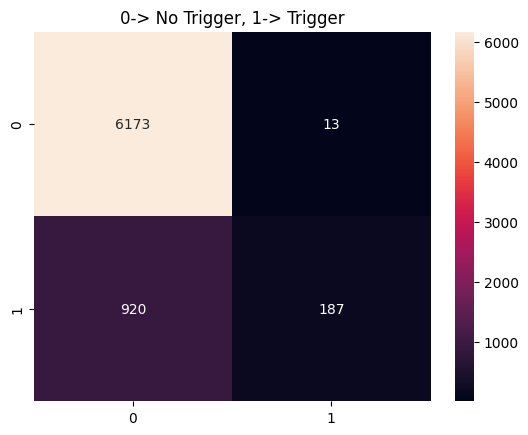

In [ ]:
# VALIDATION 

get_F1(val_data_loader, model)